# Bitcoin price forecast


In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
# dataset @ https://finance.yahoo.com/quote/BTC-USD/history/
import pandas as pd

df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727
1,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380
2,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560
3,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059
4,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556


In [40]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2019-01-18,3657.839355
1,2019-01-19,3728.568359
2,2019-01-20,3601.013672
3,2019-01-21,3576.032471
4,2019-01-22,3604.577148


In [41]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [42]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

0   2019-01-18
1   2019-01-19
2   2019-01-20
3   2019-01-21
4   2019-01-22
Name: Date, dtype: datetime64[ns]

In [43]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2019-01-18,3657.839355
2019-01-19,3728.568359
2019-01-20,3601.013672
2019-01-21,3576.032471
2019-01-22,3604.577148


In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df['Close'] = scaled_data
df.head()

,Close
Date,
2019-01-18,0.004026
2019-01-19,0.005129
2019-01-20,0.003141
2019-01-21,0.002752
2019-01-22,0.003196


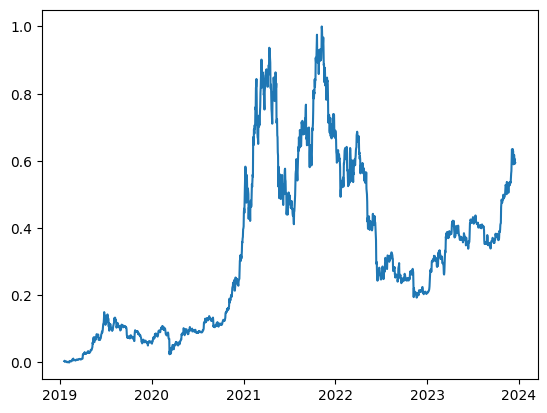

In [45]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [46]:
import numpy as np

def df_to_windowed_df(dataframe, n=3):
  target = df.loc[:,df.columns[-1]].to_numpy()
  dates = dataframe.index[n:].to_numpy()
  Y = target[n:]

  X = []
  i = 1
  while i != n + 1:
    X.append(target[n-i:-i])
    i += 1

  X.reverse()

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for j in range(0, n):
    ret_df[f'Target-{n-j}'] = X[j]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, n=5)
windowed_df.head()

,Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2019-01-23,0.004026,0.005129,0.003141,0.002752,0.003196,0.002893
1,2019-01-24,0.005129,0.003141,0.002752,0.003196,0.002893,0.003139
2,2019-01-25,0.003141,0.002752,0.003196,0.002893,0.003139,0.003121
3,2019-01-26,0.002752,0.003196,0.002893,0.003139,0.003121,0.003163
4,2019-01-27,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875


In [47]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((1791,), (1791, 5, 1), (1791,))

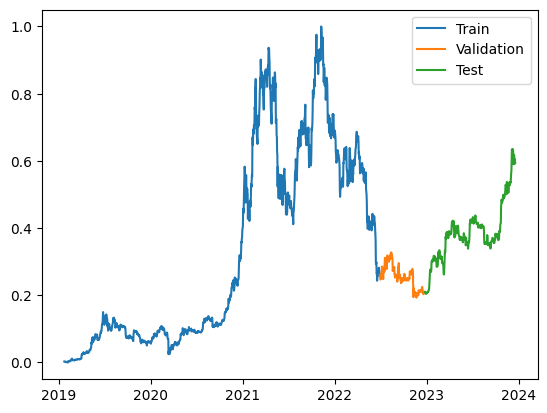

In [48]:
train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

lim_train = int(len(dates) * train_percentage)
lim_val = int(len(dates) * val_percentage)

dates_train, X_train, y_train = dates[:lim_train], X[:lim_train], y[:lim_train]
dates_val, X_val, y_val = dates[lim_train: lim_train + lim_val], X[lim_train: lim_train + lim_val], y[lim_train: lim_train + lim_val]
dates_test, X_test, y_test = dates[ lim_train + lim_val:], X[ lim_train + lim_val:], y[ lim_train + lim_val:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras import layers, regularizers

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                    layers.Dropout(0.1),
                    layers.Dense(1)])

lr_schedule = InverseTimeDecay(0.0001,
                               decay_steps=1000,
                               decay_rate=0.97,
                               staircase=False)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
32/32 [==============================] - 3s 29ms/step - loss: 0.2491 - mean_absolute_error: 0.3463 - val_loss: 0.1030 - val_mean_absolute_error: 0.1762
Epoch 2/30
32/32 [==============================] - 0s 9ms/step - loss: 0.1918 - mean_absolute_error: 0.2751 - val_loss: 0.0840 - val_mean_absolute_error: 0.1159
Epoch 3/30
32/32 [==============================] - 0s 8ms/step - loss: 0.1430 - mean_absolute_error: 0.2081 - val_loss: 0.0719 - val_mean_absolute_error: 0.0514
Epoch 4/30
32/32 [==============================] - 0s 10ms/step - loss: 0.1052 - mean_absolute_error: 0.1504 - val_loss: 0.0681 - val_mean_absolute_error: 0.0230
Epoch 5/30
32/32 [==============================] - 0s 10ms/step - loss: 0.0846 - mean_absolute_error: 0.1082 - val_loss: 0.0699 - val_mean_absolute_error: 0.0558
Epoch 6/30
32/32 [==============================] - 0s 8ms/step - loss: 0.0788 - mean_absolute_error: 0.0962 - val_loss: 0.0706 - val_mean_absolute_error: 0.0701
Epoch 7/30
32/32 [=======

32/32 [==============================] - 0s 2ms/step


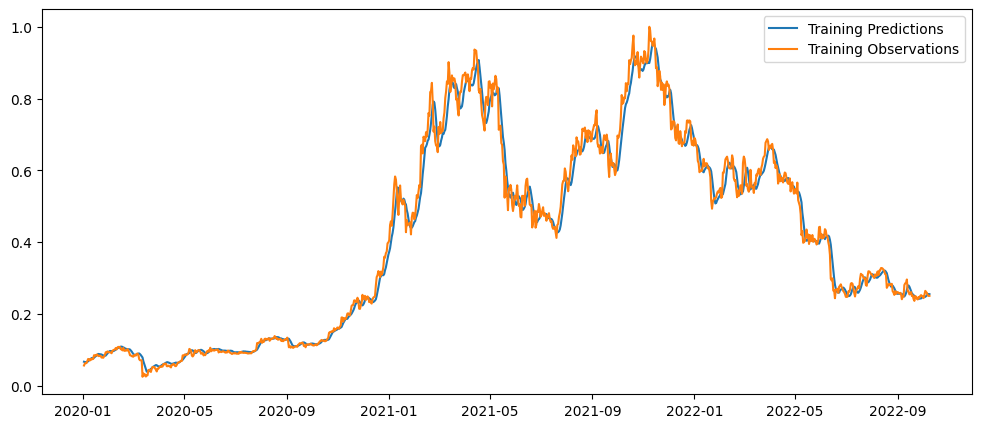

In [94]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

5/5 [==============================] - 0s 3ms/step


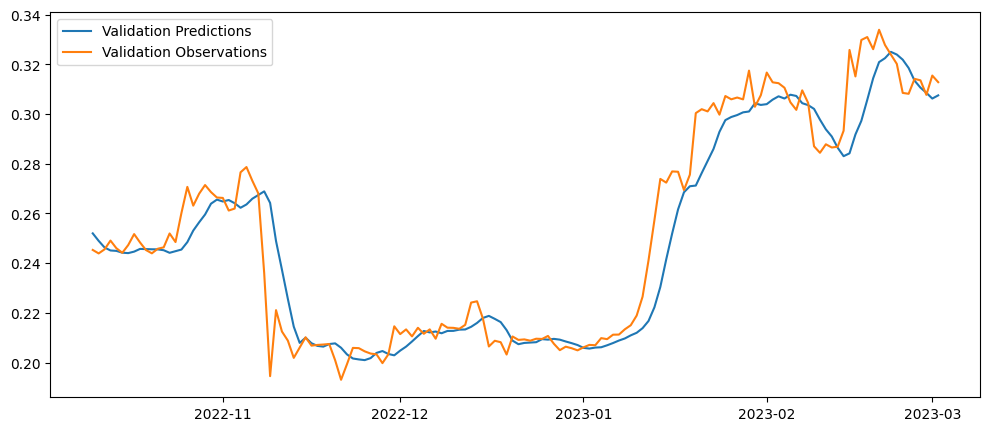

In [95]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

10/10 [==============================] - 0s 3ms/step


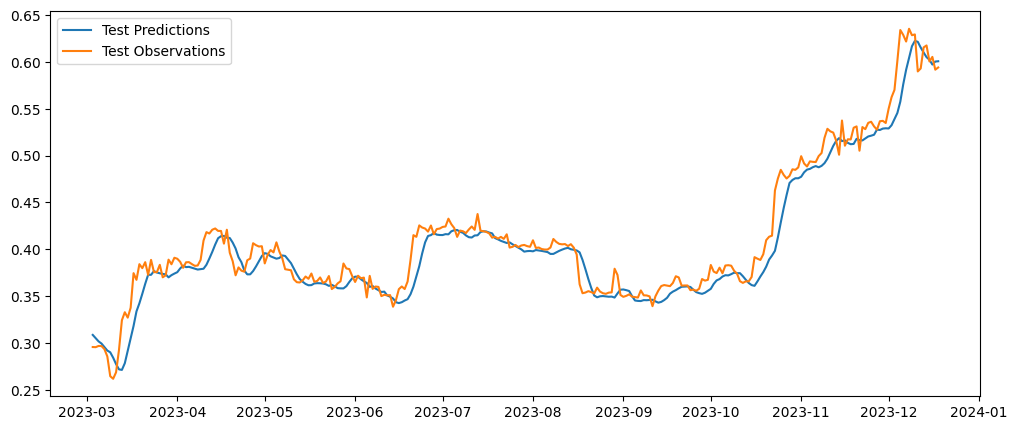

In [96]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])